In [1]:
import os
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))

# image bins: 
bins_x = torch.linspace(-30, 30, train_dset.images.shape[-2])*1e-3
bins_y = torch.linspace(-30, 30, train_dset.images.shape[-1])*1e-3

image size = 60 x 60 mm
test samples boxed in orange


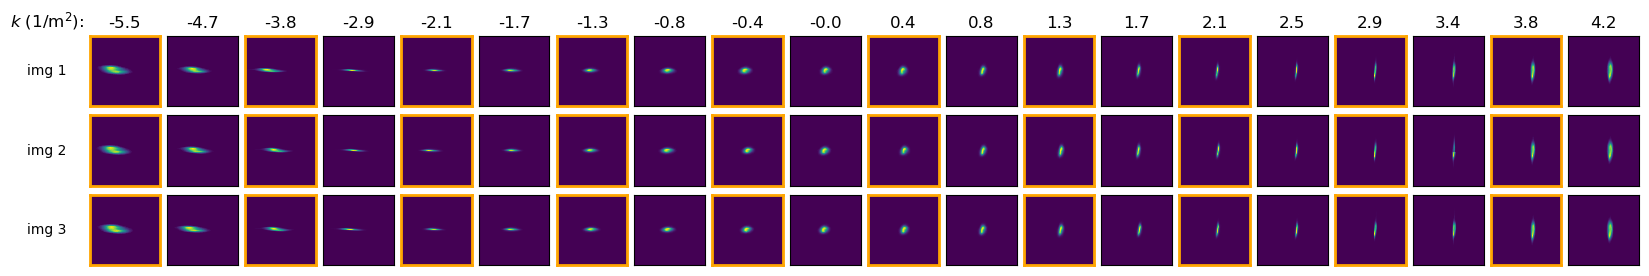

In [4]:
fig, ax = plot_scan_data(train_dset, test_dset, bins_x, bins_y)
plt.show()

In [5]:
# diagnostic beamline:
lattice = quad_drift(l_d=3.38, l_q=0.12)

# design momentum (eV)
p0c = 43e6

# diagnostic screen: 
bandwidth = (bins_x[1]-bins_x[0]) / 2
screen = ImageDiagnostic(bins_x, bins_y, bandwidth)

In [10]:
%%time

# training
pred_beam = train_1d_scan(
    train_dset,
    lattice, 
    p0c, 
    screen, 
    n_epochs = 500, 
    device = 'cuda',
    n_particles = 100_000
)

Using device: cuda
0 tensor(738882.5625, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(101824.0469, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(98464.4531, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(97559.7422, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(98101.4141, device='cuda:0', grad_fn=<MulBackward0>)
CPU times: user 4min 58s, sys: 1.19 s, total: 4min 59s
Wall time: 4min 46s


In [11]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 60 x 60 mm
test samples boxed in orange


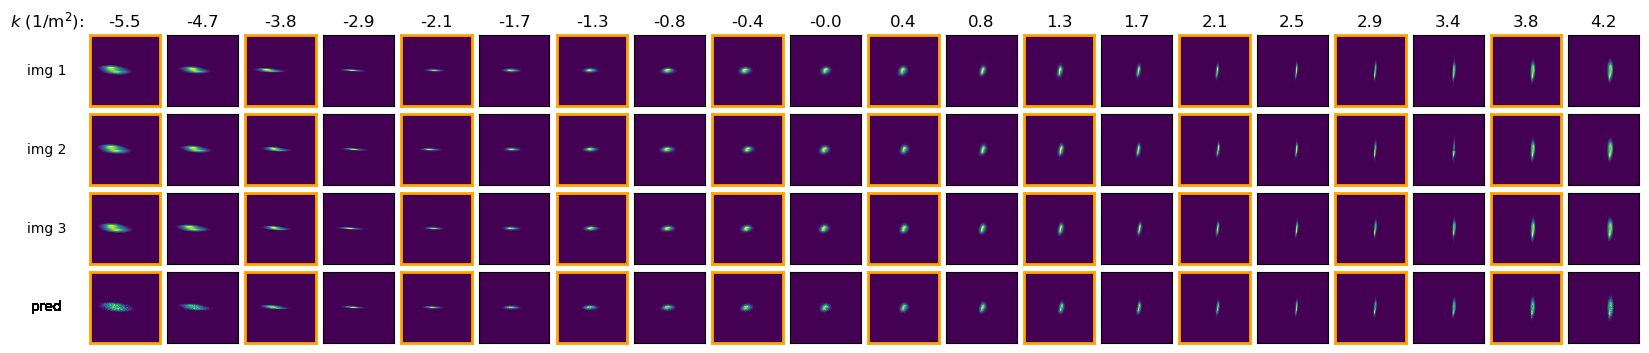

In [12]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins_x, bins_y)
plt.show()

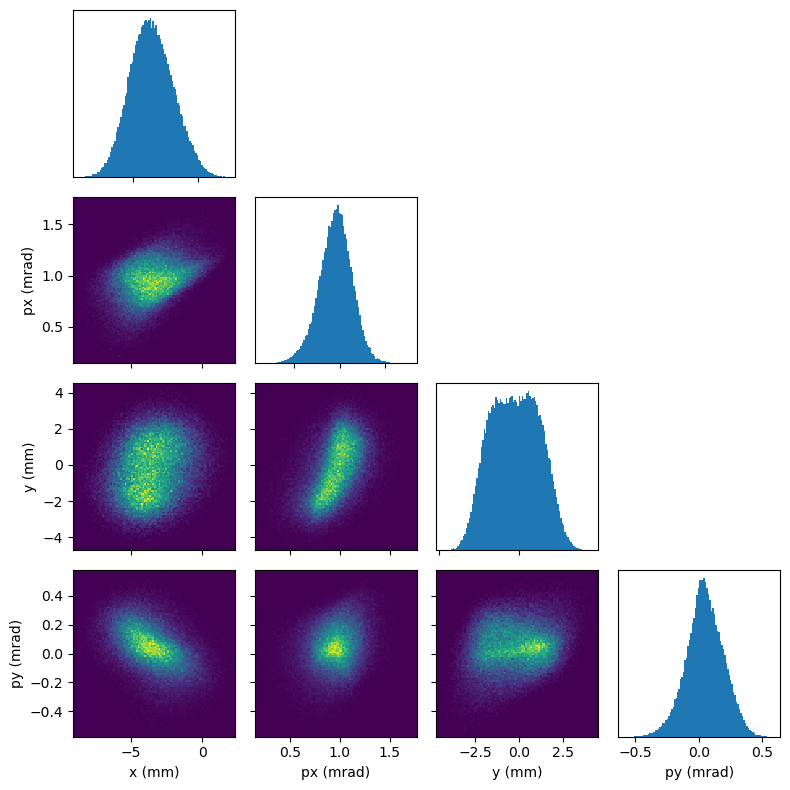

In [15]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=100,
                           background=False
                           )
fig.savefig("4d_reconstruction.png",dpi=300)
plt.show()